In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic financial news snippets (Jan 2010 - Dec 2015, ~5 snippets/month)
dates = pd.date_range(start='2010-01-01', end='2015-12-01', freq='M')
snippets = []
snippet_dates = []
positive_snippets = [
    "FoodCo reports strong Q2 earnings, demand surges.",
    "New product launch boosts FoodCo’s market share.",
    "Analysts upgrade FoodCo stock on robust sales."
]
neutral_snippets = [
    "FoodCo maintains steady production levels.",
    "Market awaits FoodCo’s next earnings report.",
    "FoodCo announces routine supply chain updates."
]
negative_snippets = [
    "FoodCo faces supply chain disruptions, sales dip.",
    "Recall issued for FoodCo product, stock falls.",
    "FoodCo reports lower-than-expected profits."
]

for date in dates:
    for _ in range(np.random.randint(4, 7)):  # 4-7 snippets per month
        sentiment = np.random.choice(['positive', 'neutral', 'negative'], p=[0.4, 0.4, 0.2])
        if sentiment == 'positive':
            snippet = np.random.choice(positive_snippets)
        elif sentiment == 'neutral':
            snippet = np.random.choice(neutral_snippets)
        else:
            snippet = np.random.choice(negative_snippets)
        snippets.append(snippet)
        snippet_dates.append(date)

# Create DataFrame
data = pd.DataFrame({'ds': snippet_dates, 'snippet': snippets})

In [3]:
data

,ds,snippet
0,2010-01-31,FoodCo announces routine supply chain updates.
1,2010-01-31,FoodCo maintains steady production levels.
2,2010-01-31,Market awaits FoodCo’s next earnings report.
3,2010-01-31,Analysts upgrade FoodCo stock on robust sales.
4,2010-01-31,FoodCo maintains steady production levels.
...,...,...
357,2015-11-30,"FoodCo reports strong Q2 earnings, demand surges."
358,2015-11-30,"FoodCo reports strong Q2 earnings, demand surges."
359,2015-11-30,FoodCo announces routine supply chain updates.
360,2015-11-30,Market awaits FoodCo’s next earnings report.


In [4]:
# Step 1: Initialize FinBERT
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set to evaluation mode

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [5]:
# Step 2: Analyze Sentiment
def get_finbert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=128, truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1).numpy()[0]
    return {'positive': probs[2], 'neutral': probs[1], 'negative': probs[0]}  # FinBERT order: neg, neu, pos

data['sentiment_scores'] = data['snippet'].apply(get_finbert_sentiment)
data['positive'] = data['sentiment_scores'].apply(lambda x: x['positive'])
data['neutral'] = data['sentiment_scores'].apply(lambda x: x['neutral'])
data['negative'] = data['sentiment_scores'].apply(lambda x: x['negative'])
data['compound'] = data['positive'] - data['negative']  # Simplified numerical score

In [6]:
# Step 3: Aggregate Monthly Sentiment
monthly_sentiment = data.groupby(data['ds'].dt.to_period('M')).agg({
    'compound': 'mean',
    'positive': 'mean',
    'neutral': 'mean',
    'negative': 'mean'
}).reset_index()
monthly_sentiment['ds'] = monthly_sentiment['ds'].dt.to_timestamp()

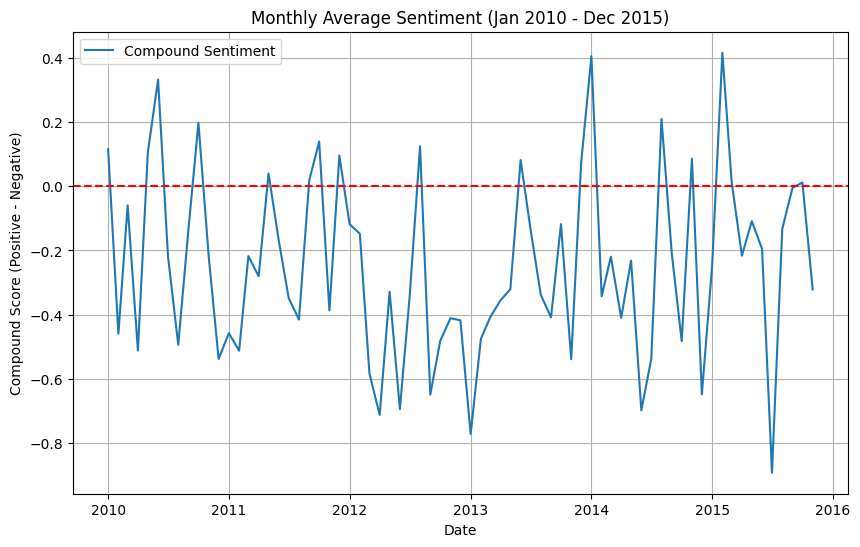

In [7]:
# Step 4: Visualize Monthly Compound Sentiment
plt.figure(figsize=(10, 6))
plt.plot(monthly_sentiment['ds'], monthly_sentiment['compound'], label='Compound Sentiment')
plt.axhline(0, color='red', linestyle='--')
plt.title('Monthly Average Sentiment (Jan 2010 - Dec 2015)')
plt.xlabel('Date')
plt.ylabel('Compound Score (Positive - Negative)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Step 6: Example Integration with Prophet
prophet_data = pd.DataFrame({
    'ds': monthly_sentiment['ds'],
    'y': 125 + 0.9 * np.random.normal(0, 28, len(dates)).cumsum() + np.random.normal(0, 10, len(dates)),
    'sentiment': monthly_sentiment['compound']
})
print("\nSample Data for Prophet with Sentiment Regressor:")
print(prophet_data.head())


Sample Data for Prophet with Sentiment Regressor:
          ds           y  sentiment
0 2010-01-01  111.723396   0.115041
1 2010-02-01  153.731829  -0.459202
2 2010-03-01  228.228996  -0.059500
3 2010-04-01  276.102034  -0.511505
4 2010-05-01  216.764656   0.104644
